# Models Notebook

This notebook will contain model iterations and feature experimention/engineering as well as continued EDA. This is a continuation of 02_mc_models notebook.

A few notes I need to keep in mind:
- We are focusing on correctly identifying the failing pumps, as this prevents people from accessing drinking water and is the most important to classify
- Because of this we will be using recall as primary metric. I may need to manually calculate as we are trying to minimize false negatives for specific class in a multiclass problem
- Other questions to explore:
    - Are there areas/regions that have more failing wells?
    - Does water quality appear to contribute to the likelihood of a well failing/needing repair?
    - How is the status of a well associated with the population using the well, if at all?
    - Is there a difference in rates of failure/repair between groundwater and surface water wells?
    - is there a difference in failure/repair with the type of pump?
    - Does the age of the well indicate liklihood of needed repair or failure?


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, make_scorer

# Ensemble/XGBoost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

#.py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.mc_functions as mcf

%matplotlib inline

This is the third time I am importing the data and doing a train test split, and I am sure it won't be the last, so I am going to write a function that takes the labels and values and creates a dataframe from them and put it in my .py file.

In [192]:
# get base dataframe from .py file
df = mcf.create_base_df()

In [10]:
df.head()

,status_group,amount_tsh,date_recorded,gps_height,installer,basin,region,population,construction_year,extraction_type_group,management_group,payment,water_quality,quantity,source_type,waterpoint_type_group
0,functional,6000.0,2011-03-14,1390,Roman,Lake Nyasa,Iringa,109,1999,gravity,user-group,pay annually,soft,enough,spring,communal standpipe
1,functional,0.0,2013-03-06,1399,GRUMETI,Lake Victoria,Mara,280,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe
2,functional,25.0,2013-02-25,686,World vision,Pangani,Manyara,250,2009,gravity,user-group,pay per bucket,soft,enough,dam,communal standpipe
3,non functional,0.0,2013-01-28,263,UNICEF,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,user-group,never pay,soft,dry,borehole,communal standpipe
4,functional,0.0,2011-07-13,0,Artisan,Lake Victoria,Kagera,0,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe


Great now I can perform my train test split and add the engineered 'age' column to both dataframes.  I want to create a function to do that as well.

In [193]:
# target variable
y = df['status_group']
# features
X = df.drop('status_group', axis=1)

In [194]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [ ]:
def add_age_column(train, test):
    # get unique basins
    unique_basin = train['basin'].unique()

    # calculate median construction_year for each basin
    med_year_per_basin = {}
    for basin in unique_basin:
        med_year = X_train[X_train['basin'] == basin].median()['construction_year']
        med_year_per_basin[basin] = med_year

    


In [17]:
X_train['construction_year'] = X_train['construction_year'].replace(0, np.nan)

In [19]:
X_train.groupby('region').std()

,amount_tsh,gps_height,population,construction_year
region,,,,
Arusha,2334.406489,298.165966,452.773500,11.784075
Dar es Salaam,2896.680793,38.561440,557.867021,11.053546
Dodoma,0.000000,0.000000,0.000000,NaN
Iringa,5125.909179,356.707701,187.494980,11.472952
Kagera,0.000000,0.000000,0.000000,NaN
Kigoma,901.812196,212.630499,602.290751,10.773641
Kilimanjaro,2407.175645,334.243659,299.731691,14.887046
Lindi,184.401722,172.688924,390.513983,13.689011
Manyara,1760.495244,354.151594,601.645048,9.823948


In [20]:
X_train.groupby('basin').std()

,amount_tsh,gps_height,population,construction_year
basin,,,,
Internal,4578.527184,752.596606,408.307213,11.779188
Lake Nyasa,2244.598160,867.152750,213.601973,9.247193
Lake Rukwa,2620.867776,736.319010,516.093226,10.804620
Lake Tanganyika,777.465768,661.037256,541.000474,11.345957
Lake Victoria,898.331752,580.677734,425.433003,11.293008
Pangani,3201.275164,514.647918,513.655048,14.480272
Rufiji,4217.530168,753.196765,351.374492,11.899687
Ruvuma / Southern Coast,773.697700,334.391970,433.030105,12.774667
Wami / Ruvu,5036.838492,293.293405,700.027492,11.872493


In [23]:
X_train.groupby('basin').median()

,amount_tsh,gps_height,population,construction_year
basin,,,,
Internal,0.0,1219.5,1.0,2002.0
Lake Nyasa,0.0,476.0,0.0,2000.0
Lake Rukwa,0.0,0.0,0.0,1989.0
Lake Tanganyika,0.0,873.0,60.0,1997.0
Lake Victoria,0.0,0.0,0.0,1998.0
Pangani,0.0,1164.0,100.0,2000.0
Rufiji,20.0,791.0,54.0,2000.0
Ruvuma / Southern Coast,0.0,340.0,200.0,1996.0
Wami / Ruvu,0.0,73.0,80.0,2004.0


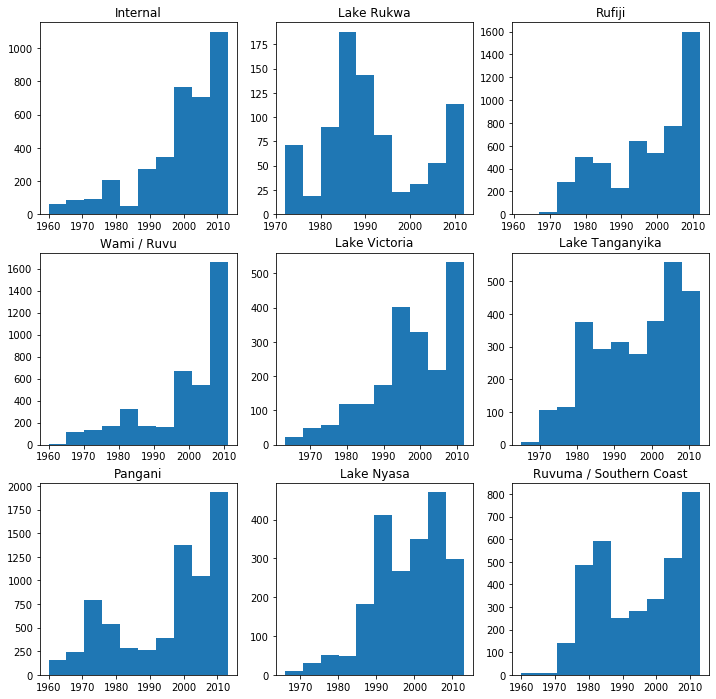

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
basin_index=0
for i in range(3):
    for j in range(3):
        ax[i,j].hist(X_train[X_train['basin'] == unique_basin[basin_index]]['construction_year'])
        ax[i, j].set_title('{}'.format(unique_basin[basin_index]))
        basin_index += 1

So after replacing all 0 values in construction_year with np.nan this is the construction_year distribution for each basin. For the most part it seems like the majority of pumps that documented construction_year were constructed more recently than not. But its clear that the majority of construction_year distributions for each basin is rather skewed so the median construction_year for each basin may still be a good way to fill in those missing values.

In [134]:
pct_missing_year_basin = {}
missing_basin = {}
total_basin = {}
for basin in unique_basin:
    missing = X_train[X_train['basin'] == basin]['construction_year'].isna().sum()
    total = len(X_train[X_train['basin'] == basin])
    total_basin[basin] = total
    missing_basin[basin] = missing
    pct_missing = (missing/total) * 100
    pct_missing_year_basin[basin] = round(pct_missing, 2)

In [39]:
pct_missing_year_basin

{'Internal': 40.54,
 'Lake Rukwa': 59.01,
 'Rufiji': 20.69,
 'Wami / Ruvu': 17.71,
 'Lake Victoria': 75.31,
 'Lake Tanganyika': 43.99,
 'Pangani': 1.64,
 'Lake Nyasa': 47.18,
 'Ruvuma / Southern Coast': 4.83}

In [133]:
missing_basin

{'Internal': 2523,
 'Lake Rukwa': 1172,
 'Rufiji': 1319,
 'Wami / Ruvu': 851,
 'Lake Victoria': 6179,
 'Lake Tanganyika': 2274,
 'Pangani': 117,
 'Lake Nyasa': 1894,
 'Ruvuma / Southern Coast': 174}

In [135]:
total_basin

{'Internal': 6224,
 'Lake Rukwa': 1986,
 'Rufiji': 6375,
 'Wami / Ruvu': 4804,
 'Lake Victoria': 8205,
 'Lake Tanganyika': 5169,
 'Pangani': 7143,
 'Lake Nyasa': 4014,
 'Ruvuma / Southern Coast': 3600}

In [138]:
df.groupby('basin')['construction_year'].value_counts()

basin        construction_year
Internal     0                    3150
             2000                  503
             2010                  323
             1990                  303
             2008                  277
                                  ... 
Wami / Ruvu  1967                    7
             1973                    5
             1960                    4
             1961                    1
             1963                    1
Name: construction_year, Length: 437, dtype: int64

Some of the basin's are missing more than half of their construction_year values, Lake Victoria basin is missing 75% of the values for construction_year, can I assume filling in the missing values with the median would be accurate enough? I think I am just going to go with it for now and see how it performs on the models, I can always change how we calculate age later if it doesn't serve the model well.

,Lake Nyasa,Lake Victoria,Pangani,Ruvuma / Southern Coast,Internal,Lake Tanganyika,Wami / Ruvu,Rufiji,Lake Rukwa
functional,3324,5100,5372,1670,4482,3107,3136,5068,1000
failing,1511,4159,3091,2497,2746,2583,2582,2471,1184
repair,250,989,477,326,557,742,269,437,270


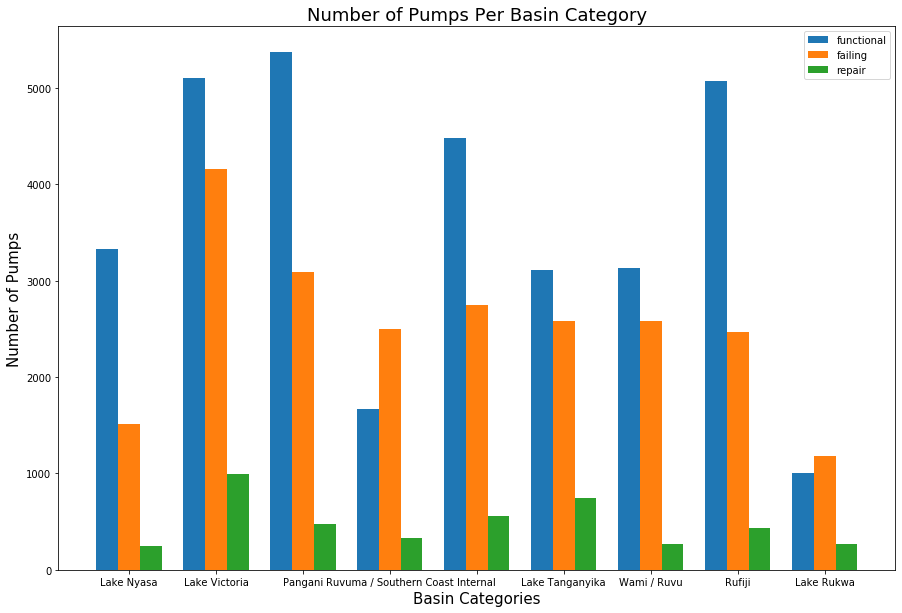

In [40]:
mcf.plot_category(df, 'basin')

I like this plot but I want to clean it up a little bit for our visual presentation. I also want to try a stacked barplot showing percentage of water well pumps for each functionality status in each basin. I will use seaborn to do this as its plots are more visually appealing. First thing I need to do is get percentage of pumps in each status_group for each basin. 

In [168]:
basins = df['basin'].unique()
b_bar = {}
m_bar = {}
t_bar = {}

for basin in unique_basin:
    tot_observs = len(df[df['basin'] == basin])
    func = len(df[(df['basin'] == basin) & (df['status_group'] == 'functional')])
    fail = len(df[(df['basin'] == basin) & (df['status_group'] == 'non functional')])
    repair = len(df[(df['basin'] == basin) & (df['status_group'] == 'functional needs repair')])
    b_bar[basin] = 100
    m_bar[basin] = round(((fail+func)/tot_observs)*100, 0)
    t_bar[basin] = round((func/tot_observs)*100, 0)

    

In [76]:
print(b_bar)
print(m_bar)
print(t_bar)

{'Internal': 100, 'Lake Rukwa': 100, 'Rufiji': 100, 'Wami / Ruvu': 100, 'Lake Victoria': 100, 'Lake Tanganyika': 100, 'Pangani': 100, 'Lake Nyasa': 100, 'Ruvuma / Southern Coast': 100}
{'Internal': 93.0, 'Lake Rukwa': 89.0, 'Rufiji': 95.0, 'Wami / Ruvu': 96.0, 'Lake Victoria': 90.0, 'Lake Tanganyika': 88.0, 'Pangani': 95.0, 'Lake Nyasa': 95.0, 'Ruvuma / Southern Coast': 93.0}
{'Internal': 58.0, 'Lake Rukwa': 41.0, 'Rufiji': 64.0, 'Wami / Ruvu': 52.0, 'Lake Victoria': 50.0, 'Lake Tanganyika': 48.0, 'Pangani': 60.0, 'Lake Nyasa': 65.0, 'Ruvuma / Southern Coast': 37.0}


Now that I have the percentage of each status_group within each basin I can plot this with a stacked barplot

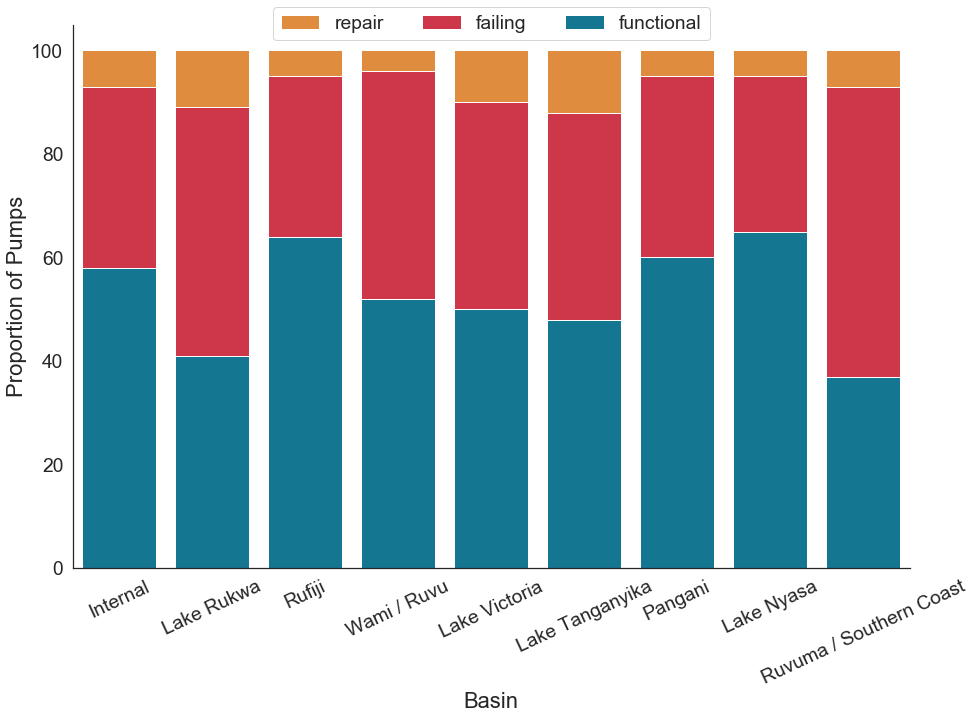

In [171]:
sns.set_context({"figure.figsize": (15, 10)})
sns.set(font_scale=1.75)
sns.set_style("white")

x = list(b_bar.keys())
y1 = list(b_bar.values())
y2 = list(m_bar.values())
y3 = list(t_bar.values())

bottom_bar = sns.barplot(x=x, y=y1, color='#fb8b24', label='repair')
middle_bar = sns.barplot(x=x, y=y2, color='#e71d36', label='failing')
top_bar = sns.barplot(x=x, y=y3, color='#0081a7', label='functional')

bottom_bar.set_xlabel('Basin', fontsize=22)
bottom_bar.set_ylabel('Proportion of Pumps', fontsize=22)
bottom_bar.set_xticklabels(x, rotation=25)

sns.despine(top=True, right=True)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3)

That's a pretty great looking plot right there. I want to make this same plot for water_quality and waterpoint_type_group

In [153]:
wp_types = df['waterpoint_type_group'].unique()
wp_b_bar = {}
wp_m_bar = {}
wp_t_bar = {}

for wp in wp_types:
    tot_observs = len(df[df['waterpoint_type_group'] == wp])
    func = len(df[(df['waterpoint_type_group'] == wp) & (df['status_group'] == 'functional')])
    fail = len(df[(df['waterpoint_type_group'] == wp) & (df['status_group'] == 'non functional')])
    repair = len(df[(df['waterpoint_type_group'] == wp) & (df['status_group'] == 'functional needs repair')])
    wp_b_bar[wp] = 100
    wp_m_bar[wp] = round(((fail+func)/tot_observs)*100, 0)
    wp_t_bar[wp] = round((func/tot_observs)*100, 0)

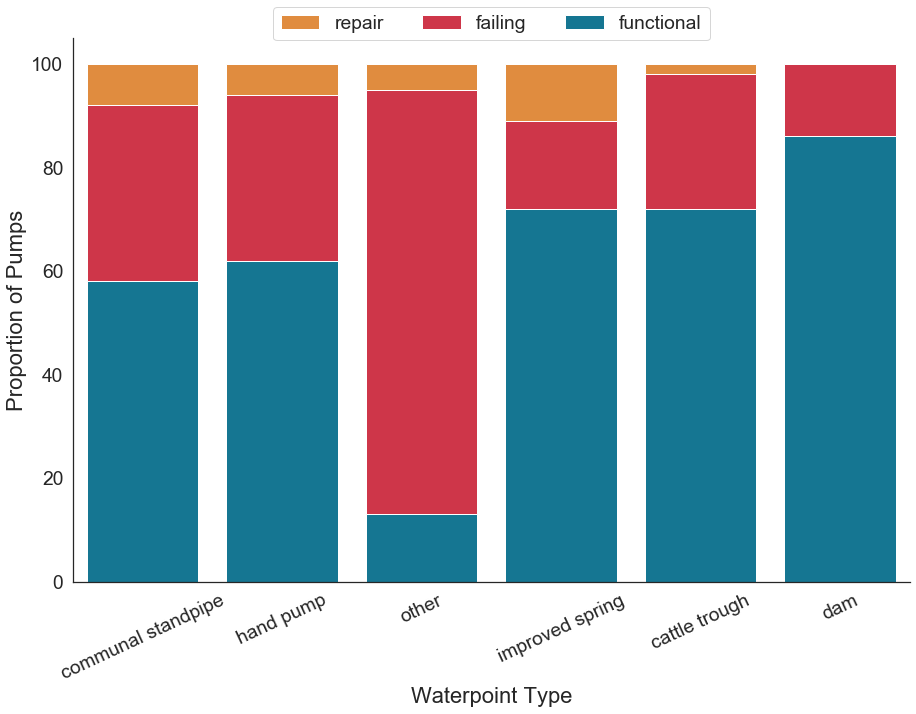

In [174]:
sns.set_context({"figure.figsize": (15, 10)})
sns.set(font_scale=1.75)
sns.set_style("white")

x = list(wp_b_bar.keys())
y1 = list(wp_b_bar.values())
y2 = list(wp_m_bar.values())
y3 = list(wp_t_bar.values())

bottom_bar = sns.barplot(x=x, y=y1, color='#fb8b24', label='repair')
middle_bar = sns.barplot(x=x, y=y2, color='#e71d36', label='failing')
top_bar = sns.barplot(x=x, y=y3, color='#0081a7', label='functional')

bottom_bar.set_xlabel('Waterpoint Type', fontsize=22)
bottom_bar.set_ylabel('Proportion of Pumps', fontsize=22)
bottom_bar.set_xticklabels(x, rotation=25)

sns.despine(top=True, right=True)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.075), ncol=3)

In [186]:
wq_types = df['water_quality'].unique()
wq_b_bar = {}
wq_m_bar = {}
wq_t_bar = {}
include = ['soft', 'salty', 'milky', 'unknown', 'coloured']

for wq in wq_types:
    if wq in include:
        tot_observs = len(df[df['water_quality'] == wq])
        func = len(df[(df['water_quality'] == wq) & (df['status_group'] == 'functional')])
        fail = len(df[(df['water_quality'] == wq) & (df['status_group'] == 'non functional')])
        repair = len(df[(df['water_quality'] == wq) & (df['status_group'] == 'functional needs repair')])
        wq_b_bar[wq] = 100
        wq_m_bar[wq] = round(((fail+func)/tot_observs)*100, 0)
        wq_t_bar[wq] = round((func/tot_observs)*100, 0)

In [187]:
wq_types

array(['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
       'salty abandoned', 'fluoride abandoned'], dtype=object)

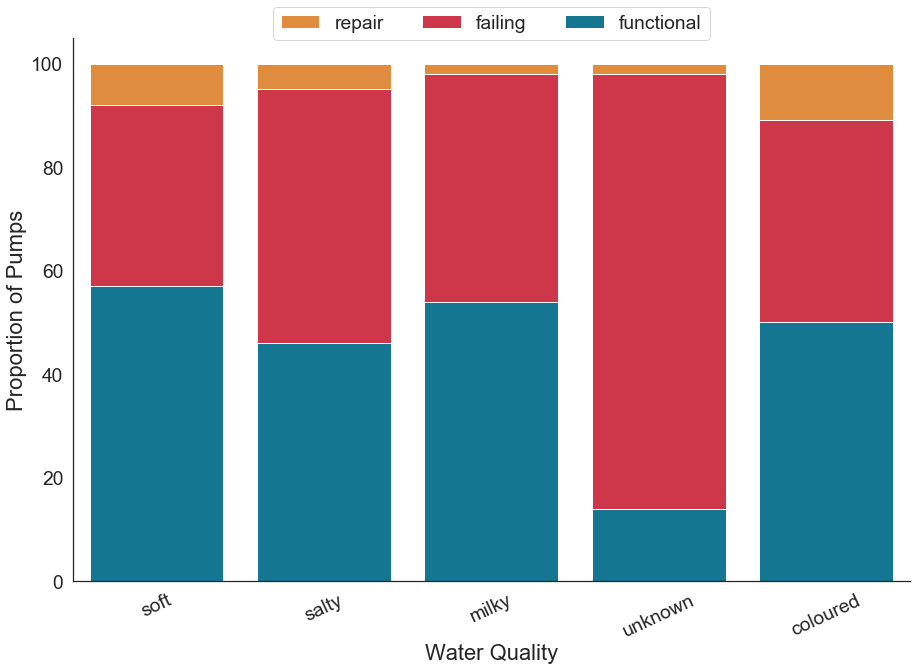

In [188]:
sns.set_context({"figure.figsize": (15, 10)})
sns.set(font_scale=1.75)
sns.set_style("white")

x = list(wq_b_bar.keys())
y1 = list(wq_b_bar.values())
y2 = list(wq_m_bar.values())
y3 = list(wq_t_bar.values())

bottom_bar = sns.barplot(x=x, y=y1, color='#fb8b24', label='repair')
middle_bar = sns.barplot(x=x, y=y2, color='#e71d36', label='failing')
top_bar = sns.barplot(x=x, y=y3, color='#0081a7', label='functional')

bottom_bar.set_xlabel('Water Quality', fontsize=22)
bottom_bar.set_ylabel('Proportion of Pumps', fontsize=22)
bottom_bar.set_xticklabels(x, rotation=25)

sns.despine(top=True, right=True)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.075), ncol=3)

,pay annually,never pay,pay per bucket,unknown,pay when scheme fails,other,pay monthly
functional,2740,11379,6090,3528,2429,611,5482
failing,655,12062,2486,4197,1208,325,1891
repair,247,1907,409,432,277,118,927


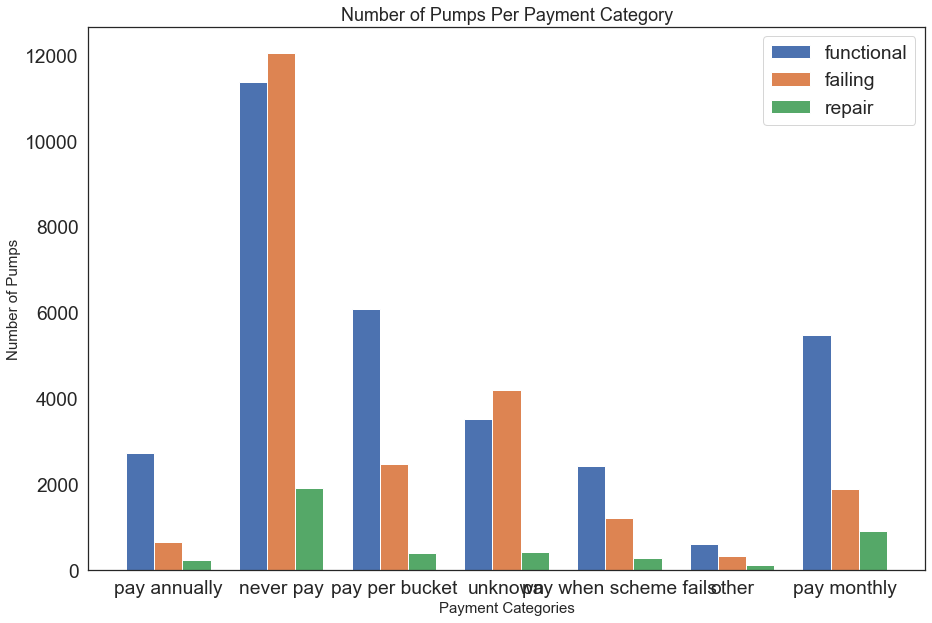

In [155]:
mcf.plot_category(df, 'payment')

,gravity,submersible,swn 80,nira/tanira,india mark ii,other,mono,wind-powered,afridev,rope pump,india mark iii,other handpump,other motorpump
functional,16048,3329,2090,5421,1448,1029,1082,50,1200,293,44,172,53
failing,8031,2597,1368,2092,873,5195,1654,60,528,141,53,172,60
repair,2701,253,212,641,79,206,129,7,42,17,1,20,9


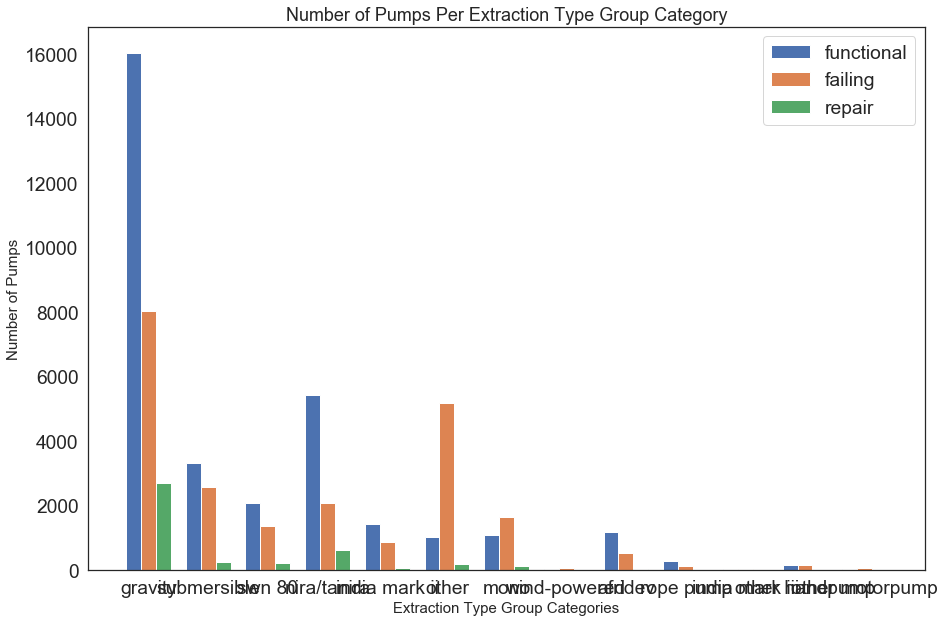

In [156]:
mcf.plot_category(df, 'extraction_type_group')

,enough,insufficient,dry,seasonal,unknown
functional,21648,7916,157,2325,213
failing,9138,5763,6052,1309,562
repair,2400,1450,37,416,14


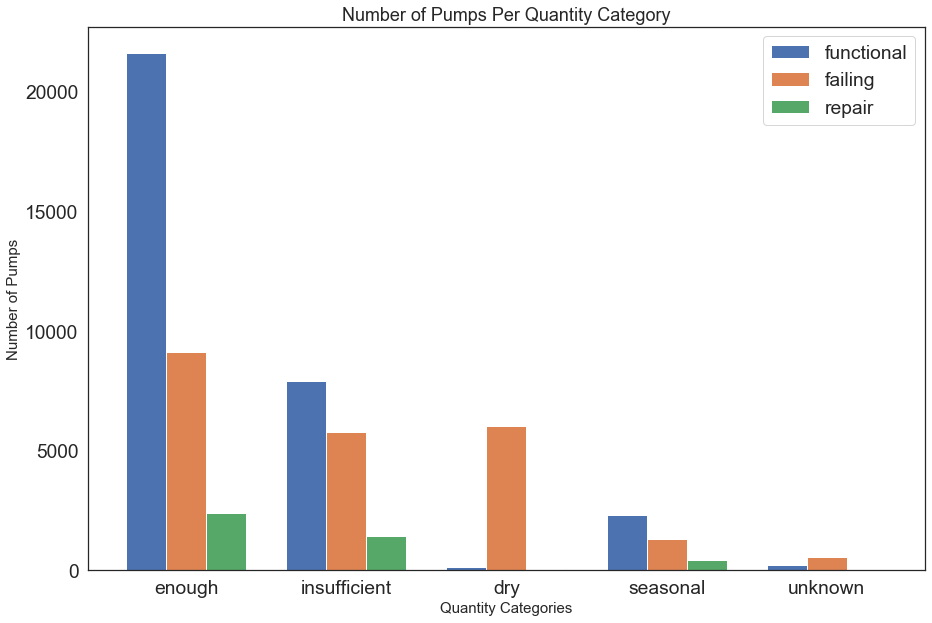

In [159]:
mcf.plot_category(df, 'quantity')

Before moving onto actually trying out some different models I want to look into gps_height a little more.

In [143]:
df.groupby('status_group').mean()['gps_height']

status_group
functional                 740.131188
functional needs repair    627.607135
non functional             574.464774
Name: gps_height, dtype: float64

So it looks here that on average a higher gps_height means theres a better chance the pump is functional, or at least that its not failing. I want to plot that and see how the overall distribution looks.

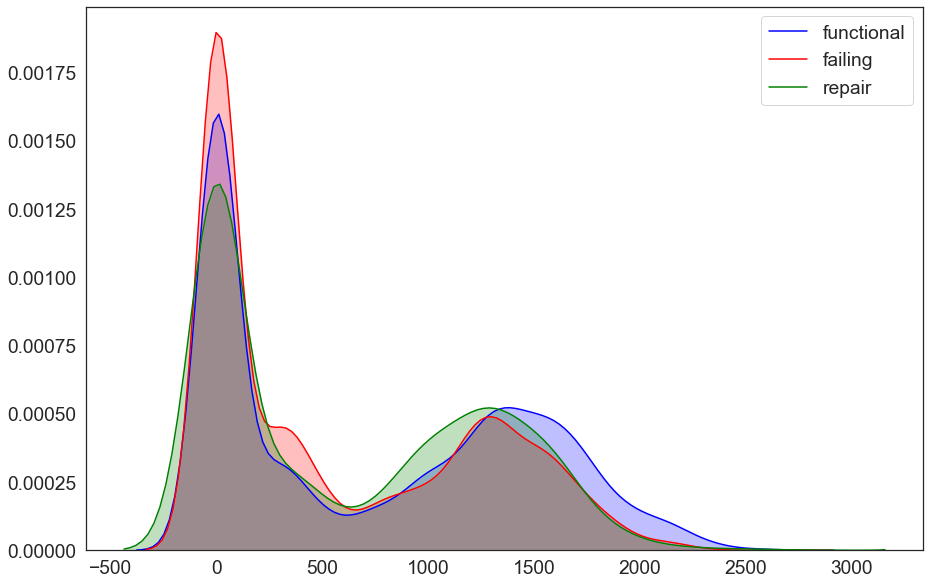

In [147]:
sns.kdeplot(df[df['status_group'] == 'functional']['gps_height'], color='blue', label='functional', shade=True)
sns.kdeplot(df[df['status_group'] == 'non functional']['gps_height'], color='red', label='failing', shade=True)
sns.kdeplot(df[df['status_group'] == 'functional needs repair']['gps_height'], color='green', label='repair', shade=True)

It seems like all the status_groups have the most pumps at sealevel. Failing pumps are the highest here and are lower than functional and need repair as gps_height increases which is actually the opposite of what I thought. Maybe the higher areas are more populated or aren't as poor as some of the lower areas. At the highest points functional pumps are more common than failing or those that need repairs but only slightly.

Those plots were created for our mid-week visual presentation. I will now proceed to more modeling and feature exploration/engineering. I want to write a function that performs a KFold on the data and calculates model metric for multiple splits and then aggregates these into a sinlge metric (recall). This function will also utilize the plot_confusion_matrix function that will plot the a confusion_matrix for both the training and testing data.

In [254]:
def cross_val_metrics(x_train, x_test, true_train, true_test, model, n, cat_vars, num_vars):

    #instanitate KFold with n splilts
    folds = KFold(n_splits=n)

    # cross_val over n splits
    train_recall = []
    val_recall = []
    for train, val in folds.split(x_train):

        # process data
        x_train_f, x_val_f = mcf.process_data(x_train.iloc[train], x_train.iloc[val], cat_vars, num_vars)

        # fit model on processed training data
        model.fit(x_train_f, true_train.iloc[train])

        # predictions for train and val data
        train_preds = model.predict(x_train_f)
        val_preds = model.predict(x_val_f)

        # calculate recall and append to list
        train_recall.append(recall_score(true_train.iloc[train], train_preds, average='weighted'))
        val_recall.append(recall_score(true_train.iloc[val], val_preds, average='weighted'))

    # print average recall score
    print('Training Recall: {}'.format(np.mean(train_recall)))
    print('Val Recall: {}'.format(np.mean(val_recall)))

    # process data for overall score and confusion matrix
    x_train_, x_test_ = mcf.process_data(x_train, x_test, cat_vars, num_vars)

    # fit model for cm
    model.fit(x_train_, true_train)

    # make predictions
    train_pred = model.predict(x_train_)
    test_pred = model.predict(x_test_)

    # print recall score for training and testing data
    print('Training Recall: {}'.format(recall_score(true_train, train_pred, average='weighted')))
    print('Testing Recall: {}'.format(recall_score(true_test, test_pred, average='weighted')))
    
    # confusion_matrix for training and testing data
    print('Training CM:')
    print(mcf.plot_confusion_matrix(true_train, train_pred))
    print('Testing CM:')
    print(mcf.plot_confusion_matrix(true_test, test_pred))

    return model

Now I want to test out this function with. I will use a small amount of features to test it out.

In [251]:
X_train.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'installer', 'basin',
       'region', 'population', 'construction_year', 'extraction_type_group',
       'management_group', 'payment', 'water_quality', 'quantity',
       'source_type', 'waterpoint_type_group'],
      dtype='object')

In [252]:
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
num_vars = ['amount_tsh', 'gps_height', 'population']
cat_vars = ['basin', 'extraction_type_group', 'management_group', 'water_quality', 'quantity', 'source_type', 'waterpoint_type_group']
model1 = cross_val_metrics(X_train, X_test, y_train, y_test, logreg, 10, cat_vars, num_vars)

Training Recall: 0.6786662925551814
Val Recall: 0.6779461279461281
Training Recall: 0.6796717171717171
Testing Recall: 0.6781144781144781
Training CM:
            Functional  Repair  Failing
Functional       21356    2284     2162
Repair            2064     931      471
Failing           6940    1301    10011
Testing CM:
            Functional  Repair  Failing
Functional        5339     586      532
Repair             511     239      101
Failing           1764     330     2478


In [253]:
X_train.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'installer', 'basin',
       'region', 'population', 'construction_year', 'extraction_type_group',
       'management_group', 'payment', 'water_quality', 'quantity',
       'source_type', 'waterpoint_type_group'],
      dtype='object')

In [241]:
model1

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Well the function seems to be working, but I am always a little hesitant that something is wrong that I am not noticing. So I am going to try getting the confusion matrix of this same model and see how it compares to the function.

In [243]:
X_train_f, X_test_f = mcf.process_data(X_train, X_test, cat_vars, num_vars)

In [244]:
logreg.fit(X_train_f, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [245]:
train_pred = logreg.predict(X_train_f)
test_pred = logreg.predict(X_test_f)

In [247]:
print(mcf.plot_confusion_matrix(y_train, train_pred))
mcf.plot_confusion_matrix(y_test, test_pred)

Functional  Repair  Failing
Functional       21356    2284     2162
Repair            2064     931      471
Failing           6940    1301    10011


,Functional,Repair,Failing
Functional,5339,586,532
Repair,511,239,101
Failing,1764,330,2478


Great it seems to work as intended. Now I can begin to experiment with differnet models and different features to try and get the most accurate model possible.

In [265]:
df.columns

Index(['status_group', 'amount_tsh', 'date_recorded', 'gps_height',
       'installer', 'basin', 'region', 'population', 'construction_year',
       'extraction_type_group', 'management_group', 'payment', 'water_quality',
       'quantity', 'source_type', 'waterpoint_type_group'],
      dtype='object')

This notebook has gotten a little messy so I am going to continue this work in a new notebook. I will be able to utilize the function defined above as I put it in my .py file.